# MLB Pitch Type Analysis

## Overview

I analyzed pitches thrown in Major League Baseball in order to figure out which features of pitching contributed to getting outs.  Although the ability of a pitcher to throw certain types of pitches effectively is crucial, this analysis seeks to find the best attributes for a player to strive for to be successful.  If a team understands which variables or combinations of variables maximize outs, it can find ways to teach young prospects to achieve such results, as well as continue to coach toward those objectives as players move up though the system. 

## Business Problem

Use factors from the data to determine which ones are most significant in recording outs and make good predictions based on these factors?

In [39]:
# import packages

import numpy as np
import pandas as pd
from collections import defaultdict

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay

from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import string
import re

## Data Overview

In [40]:
# read in datasets

atbats = pd.read_csv('Data/atbats.csv')
pitches = pd.read_csv('Data/pitches.csv')
atbats19 = pd.read_csv('Data/2019_atbats.csv')
pitches19 = pd.read_csv('Data/2019_pitches.csv')

In [41]:
atbats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740389 entries, 0 to 740388
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   ab_id       740389 non-null  int64 
 1   batter_id   740389 non-null  int64 
 2   event       740389 non-null  object
 3   g_id        740389 non-null  int64 
 4   inning      740389 non-null  int64 
 5   o           740389 non-null  int64 
 6   p_score     740389 non-null  int64 
 7   p_throws    740389 non-null  object
 8   pitcher_id  740389 non-null  int64 
 9   stand       740389 non-null  object
 10  top         740389 non-null  bool  
dtypes: bool(1), int64(7), object(3)
memory usage: 57.2+ MB


In [42]:
atbats19.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185245 entries, 0 to 185244
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   inning      185245 non-null  int64 
 1   top         185245 non-null  int64 
 2   ab_id       185245 non-null  int64 
 3   g_id        185245 non-null  int64 
 4   p_score     185245 non-null  int64 
 5   batter_id   185245 non-null  int64 
 6   pitcher_id  185245 non-null  int64 
 7   stand       185245 non-null  object
 8   p_throws    185245 non-null  object
 9   event       185245 non-null  object
 10  o           185245 non-null  int64 
dtypes: int64(8), object(3)
memory usage: 15.5+ MB


In [43]:
# rearrange columns in atbats to match column order of atbats19

atbats = atbats[['inning', 'top', 'ab_id', 'g_id', 'p_score', 'batter_id', 'pitcher_id', 'stand', 'p_throws', 'event', 'o']]
atbats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740389 entries, 0 to 740388
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   inning      740389 non-null  int64 
 1   top         740389 non-null  bool  
 2   ab_id       740389 non-null  int64 
 3   g_id        740389 non-null  int64 
 4   p_score     740389 non-null  int64 
 5   batter_id   740389 non-null  int64 
 6   pitcher_id  740389 non-null  int64 
 7   stand       740389 non-null  object
 8   p_throws    740389 non-null  object
 9   event       740389 non-null  object
 10  o           740389 non-null  int64 
dtypes: bool(1), int64(7), object(3)
memory usage: 57.2+ MB


In [44]:
# concatenate the two atbats Dataframes

atbats_all = pd.concat([atbats, atbats19], ignore_index=True, sort=False)
atbats_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 925634 entries, 0 to 925633
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   inning      925634 non-null  int64 
 1   top         925634 non-null  int64 
 2   ab_id       925634 non-null  int64 
 3   g_id        925634 non-null  int64 
 4   p_score     925634 non-null  int64 
 5   batter_id   925634 non-null  int64 
 6   pitcher_id  925634 non-null  int64 
 7   stand       925634 non-null  object
 8   p_throws    925634 non-null  object
 9   event       925634 non-null  object
 10  o           925634 non-null  int64 
dtypes: int64(8), object(3)
memory usage: 77.7+ MB


In [45]:
# drop columns in atbats_all DataFrame that aren't useful

atbats_all = atbats_all.drop(['top', 'p_score', 'o'], axis=1)

In [46]:
# rename some columns in pitches to match those that I renamed in the pitches19 csz before importing

pitches.rename(columns = {'px': 'horiz_loc', 'pz': 'vert_loc', 'pfx_x': 'horiz_move', 'pfx_z': 'vert_move'}, inplace=True)

In [47]:
# concatenate the two pitches Dataframes

pitches_all = pd.concat([pitches, pitches19], ignore_index=True, sort=False)
pitches_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3595944 entries, 0 to 3595943
Data columns (total 40 columns):
 #   Column           Dtype  
---  ------           -----  
 0   horiz_loc        float64
 1   vert_loc         float64
 2   start_speed      float64
 3   end_speed        float64
 4   spin_rate        object 
 5   spin_dir         object 
 6   break_angle      float64
 7   break_length     float64
 8   break_y          float64
 9   ax               float64
 10  ay               float64
 11  az               float64
 12  sz_bot           float64
 13  sz_top           float64
 14  type_confidence  object 
 15  vx0              float64
 16  vy0              float64
 17  vz0              float64
 18  x                object 
 19  x0               float64
 20  y                object 
 21  y0               float64
 22  z0               float64
 23  horiz_move       float64
 24  vert_move        float64
 25  nasty            float64
 26  zone             object 
 27  code        

In [48]:
# drop columns in pitches_all DataFrame that aren't useful

pitches_all = pitches_all.drop(['ax', 'ay', 'az', 'sz_bot', 'sz_top', 'type_confidence', 'vx0', 'vy0', 'vz0', 
              'x', 'x0', 'y', 'y0', 'z0', 'horiz_move', 'vert_move', 'nasty', 'zone',
              'code', 'type', 'event_num', 'b_score'], axis=1)

The DataFrames with the data on pitches contained every pitch in every at bat, but I only need the final pitch that resulted in a play.  Therefore, I'll drop the pitches in each at bat that didn't end the at bat.

In [49]:
# drop duplicates of ab_id in pitches_all, keeping only the last entry for each

pitches_all = pitches_all.drop_duplicates('ab_id', keep='last')
pitches_all = pitches_all.reset_index(drop=True)
pitches_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 925461 entries, 0 to 925460
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   horiz_loc     919761 non-null  float64
 1   vert_loc      919761 non-null  float64
 2   start_speed   919786 non-null  float64
 3   end_speed     919786 non-null  float64
 4   spin_rate     919761 non-null  object 
 5   spin_dir      919761 non-null  object 
 6   break_angle   919761 non-null  float64
 7   break_length  919761 non-null  float64
 8   break_y       919761 non-null  float64
 9   pitch_type    919761 non-null  object 
 10  ab_id         925461 non-null  float64
 11  b_count       925461 non-null  float64
 12  s_count       925461 non-null  float64
 13  outs          925461 non-null  float64
 14  pitch_num     925461 non-null  float64
 15  on_1b         925461 non-null  float64
 16  on_2b         925461 non-null  float64
 17  on_3b         925461 non-null  float64
dtypes: f

Next, I need to merge the two DataFrames (atbats_all and pitches_all) on the ab_id column.

In [50]:
# change ab_id in atbats_all from integers to strings

atbats_all['ab_id'] = atbats_all['ab_id'].astype(str)
atbats_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 925634 entries, 0 to 925633
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   inning      925634 non-null  int64 
 1   ab_id       925634 non-null  object
 2   g_id        925634 non-null  int64 
 3   batter_id   925634 non-null  int64 
 4   pitcher_id  925634 non-null  int64 
 5   stand       925634 non-null  object
 6   p_throws    925634 non-null  object
 7   event       925634 non-null  object
dtypes: int64(4), object(4)
memory usage: 56.5+ MB


In [51]:
# change ab_id in pitches_all from floats to strings

pitches_all['ab_id'] = pitches_all['ab_id'].astype(str)

In [52]:
# remove the decimal in ab_id of pitches_all to match the ab_id of atbats_all

pitches_all['ab_id'] = pitches_all['ab_id'].str[:-2]

In [53]:
# merge the DataFrames

df = atbats_all.merge(pitches_all, on='ab_id')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 925461 entries, 0 to 925460
Data columns (total 25 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   inning        925461 non-null  int64  
 1   ab_id         925461 non-null  object 
 2   g_id          925461 non-null  int64  
 3   batter_id     925461 non-null  int64  
 4   pitcher_id    925461 non-null  int64  
 5   stand         925461 non-null  object 
 6   p_throws      925461 non-null  object 
 7   event         925461 non-null  object 
 8   horiz_loc     919761 non-null  float64
 9   vert_loc      919761 non-null  float64
 10  start_speed   919786 non-null  float64
 11  end_speed     919786 non-null  float64
 12  spin_rate     919761 non-null  object 
 13  spin_dir      919761 non-null  object 
 14  break_angle   919761 non-null  float64
 15  break_length  919761 non-null  float64
 16  break_y       919761 non-null  float64
 17  pitch_type    919761 non-null  object 
 18  b_co

In [54]:
# sanity check

df.head()

,inning,ab_id,g_id,batter_id,pitcher_id,stand,p_throws,event,horiz_loc,vert_loc,...,break_length,break_y,pitch_type,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b
0,1,2015000001,201500001,572761,452657,L,L,Groundout,0.627,2.397,...,3.7,23.7,FF,2.0,2.0,0.0,6.0,0.0,0.0,0.0
1,1,2015000002,201500001,518792,452657,L,L,Double,-0.257,2.047,...,4.8,23.8,FC,1.0,0.0,1.0,2.0,0.0,0.0,0.0
2,1,2015000003,201500001,407812,452657,R,L,Single,-0.286,1.830,...,4.8,23.7,FF,2.0,0.0,1.0,3.0,0.0,1.0,0.0
3,1,2015000004,201500001,425509,452657,R,L,Strikeout,-0.711,1.971,...,11.0,23.9,CU,0.0,2.0,1.0,3.0,1.0,0.0,0.0
4,1,2015000005,201500001,571431,452657,L,L,Strikeout,-1.681,0.875,...,5.8,23.8,FC,1.0,2.0,2.0,5.0,1.0,0.0,0.0


In [55]:
df['pitch_type'].isna().sum()

5700

In [56]:
df = df[df['pitch_type'].notna()]
df = df.reset_index(drop=True)

The spin rate and spin direction columns contain object type values because there are almost 183,000 of them that are marked "placeholder" rather than a valid number.  I don't think imputing an average or anything else for these makes sense because different pitches have different ranges of values.  Instead, I'm removing those entries and converting the others to float types.

In [57]:
# remove 'placeholder' entries for spin_rate (spin_dir has 'placeholder' for the same rows)

df = df[df['spin_rate'] != 'placeholder']

In [58]:
# change spin_rate and spin_dir to floats

df['spin_rate'] = df['spin_rate'].astype(float)
df['spin_dir'] = df['spin_dir'].astype(float)

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 736325 entries, 0 to 736324
Data columns (total 25 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   inning        736325 non-null  int64  
 1   ab_id         736325 non-null  object 
 2   g_id          736325 non-null  int64  
 3   batter_id     736325 non-null  int64  
 4   pitcher_id    736325 non-null  int64  
 5   stand         736325 non-null  object 
 6   p_throws      736325 non-null  object 
 7   event         736325 non-null  object 
 8   horiz_loc     736325 non-null  float64
 9   vert_loc      736325 non-null  float64
 10  start_speed   736325 non-null  float64
 11  end_speed     736325 non-null  float64
 12  spin_rate     736325 non-null  float64
 13  spin_dir      736325 non-null  float64
 14  break_angle   736325 non-null  float64
 15  break_length  736325 non-null  float64
 16  break_y       736325 non-null  float64
 17  pitch_type    736325 non-null  object 
 18  b_co

Now that all of the data is combined into one DataFrame, I'll take a look at the pitch types.

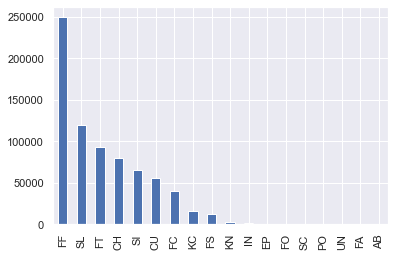

In [60]:
df['pitch_type'].value_counts().plot(kind='bar')
plt.show()

I'm not interested in any pitches accounting for less than 1% of the total...except for knuckleballs because I'm curious about them.  I'll only look at the top 10 most frequent pitch types.

In [61]:
# create a list of the top 10 most used pitches

pitch_type_keep = ['FF', 'SL', 'FT', 'CH', 'SI', 'CU', 'FC', 'KC', 'FS', 'KN']

In [62]:
# remove pitches not in the top 10

df = df[df['pitch_type'].isin(pitch_type_keep)]
df = df.reset_index(drop=True)

In [63]:
# change pitch type abbreviations to the full names of pitches

df.loc[df['pitch_type'] == 'FF', 'pitch_type'] = 'Four-seam Fastball'
df.loc[df['pitch_type'] == 'FC', 'pitch_type'] = 'Cutter'
df.loc[df['pitch_type'] == 'CU', 'pitch_type'] = 'Curveball'
df.loc[df['pitch_type'] == 'FT', 'pitch_type'] = 'Two-seam Fastball'
df.loc[df['pitch_type'] == 'CH', 'pitch_type'] = 'Changeup'
df.loc[df['pitch_type'] == 'SL', 'pitch_type'] = 'Slider'
df.loc[df['pitch_type'] == 'SI', 'pitch_type'] = 'Sinker'
df.loc[df['pitch_type'] == 'KC', 'pitch_type'] = 'Knuckle Curve'
df.loc[df['pitch_type'] == 'FS', 'pitch_type'] = 'Splitter'
df.loc[df['pitch_type'] == 'KN', 'pitch_type'] = 'Knuckleball'

In [64]:
# sanity check

df['pitch_type'].value_counts(normalize=True)

Four-seam Fastball    0.339737
Slider                0.162686
Two-seam Fastball     0.126488
Changeup              0.109540
Sinker                0.088556
Curveball             0.075603
Cutter                0.054238
Knuckle Curve         0.021896
Splitter              0.017214
Knuckleball           0.004042
Name: pitch_type, dtype: float64

The dependent variable is the outcome of the at bat, which is provided in the event column.

In [65]:
df['event'].value_counts()

Strikeout               156539
Groundout               134485
Single                  108422
Flyout                   80482
Walk                     56720
Lineout                  44795
Pop Out                  34341
Double                   33060
Home Run                 22149
Forceout                 15064
Grounded Into DP         14671
Hit By Pitch              6913
Field Error               6374
Sac Fly                   4760
Sac Bunt                  3936
Triple                    3443
Double Play               1801
Runner Out                1562
Bunt Groundout            1247
Fielders Choice Out       1247
Strikeout - DP             576
Bunt Pop Out               567
Fielders Choice            395
Batter Interference        156
Catcher Interference       150
Sac Fly DP                  76
Bunt Lineout                52
Triple Play                 20
Sacrifice Bunt DP            4
Name: event, dtype: int64

I want to focus on outcomes that are related directly to an at bat's final pitch, but there are some events given that can be considered unrelated to the specific pitch.  Those rows, therefore, can be removed.  Looking at the list, I'm also going to remove the events that were documented fewer than 10 times.  Some of these are not very clear, and they don't add enough weight to the problem anyway.

In [66]:
# create a list of events that aren't affected by the pitch

drop_events = ['Batter Interference', 'Catcher Interference', 'Caught Stealing 2B',
               'Pickoff Caught Stealing 2B', 'Fan Interference', 'Pickoff 1B',
               'Caught Stealing Home', 'Caught Stealing 3B', 'Pickoff 2B',
               'Sacrifice Bunt DP', 'Wild Pitch', 'Pickoff Caught Stealing Home',
               'Pickoff 3B', 'Runner Double Play', 'Sac Bunt Double Play',
               'Game Advisory', 'Intent Walk', 'Pickoff Caught Stealing 3B',
               'Passed Ball', 'Stolen Base 2B', 'Pickoff Error 1B']

In [67]:
# drop rows with events in drop_events

df = df.drop(df[df['event'].isin(drop_events)].index)
df = df.reset_index(drop=True)

In [68]:
df['event'].value_counts()

Strikeout              156539
Groundout              134485
Single                 108422
Flyout                  80482
Walk                    56720
Lineout                 44795
Pop Out                 34341
Double                  33060
Home Run                22149
Forceout                15064
Grounded Into DP        14671
Hit By Pitch             6913
Field Error              6374
Sac Fly                  4760
Sac Bunt                 3936
Triple                   3443
Double Play              1801
Runner Out               1562
Bunt Groundout           1247
Fielders Choice Out      1247
Strikeout - DP            576
Bunt Pop Out              567
Fielders Choice           395
Sac Fly DP                 76
Bunt Lineout               52
Triple Play                20
Name: event, dtype: int64

The pitcher's goal is to get outs, so I'll break down the event variable into those that result in outs and those that don't.  One exception is the 'Field Error' event, which I will identify as an out result since the only reason an out wasn't recorded (according to the official scorer) in such an event was the defense of the pitcher's team and not the pitch itself.  The result of the pitch should have been an out.

In [69]:
# create a list of events that do not result in an out

no_out = ['Single', 'Walk', 'Double', 'Home Run', 'Hit By Pitch', 'Triple']

In [70]:
# create numerical categories for out or no out

def out_made(event):
    if event in no_out:
        return 0
    else:
        return 1

In [71]:
# add new column

df['out_made'] = df['event'].apply(out_made)

df['out_made'].value_counts(normalize=True)

1    0.685555
0    0.314445
Name: out_made, dtype: float64

I want to look at how the speed of the pitch may influence the likelihood of making an out.

In [72]:
# split the DataFrame into outs and no outs

df_out = df[df['out_made'] == 1]
df_out = df_out.reset_index(drop=True)

df_no_out = df[df['out_made'] == 0]
df_no_out = df_no_out.reset_index(drop=True)

In [73]:
df_out['start_speed'].mean(), df_out['start_speed'].std()

(88.30201216723991, 5.902443454117017)

In [74]:
df_no_out['start_speed'].mean(), df_no_out['start_speed'].std()

(89.04677101258308, 5.640379974238034)

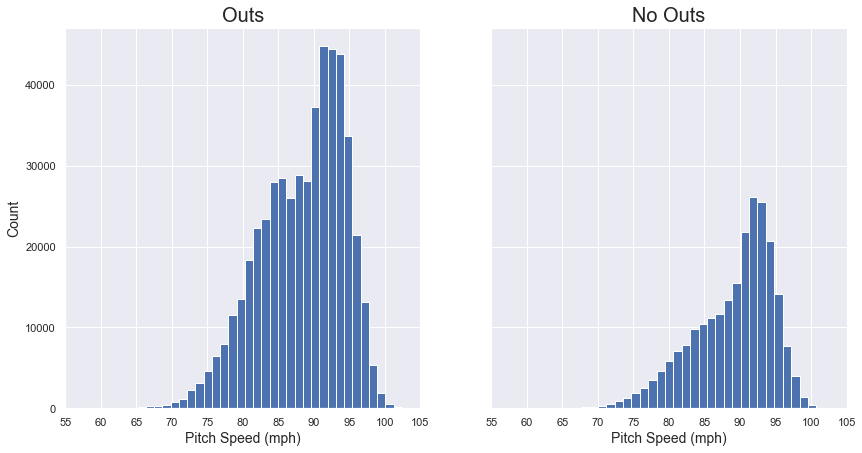

In [75]:
# plot the histograms

sns.set_theme()

x_out = df_out['start_speed']
x_no_out = df_no_out['start_speed']

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(14,7))
ax[0].hist(x_out, bins=50)
ax[1].hist(x_no_out, bins=50)
ax[0].set_title('Outs', fontsize=20)
ax[1].set_title('No Outs', fontsize=20)
ax[0].set_ylabel('Count', fontsize=14)
ax[0].set_xlabel('Pitch Speed (mph)', fontsize=14)
ax[1].set_xlabel('Pitch Speed (mph)', fontsize=14)
ax[0].set_xlim(55, 100)
ax[1].set_xlim(55, 100)
ax[0].set_xticks(ticks=np.arange(55, 110, 5))
ax[1].set_xticks(ticks=np.arange(55, 110, 5));

There is no real difference in getting outs when it comes to pitch speed alone.  

Let's see how spin rate looks.

In [76]:
df_out['spin_rate'].mean(), df_out['spin_rate'].std()

(1688.0951689377523, 689.2428735507207)

In [77]:
df_no_out['spin_rate'].mean(), df_no_out['spin_rate'].std()

(1772.3742176223527, 658.0080875913823)

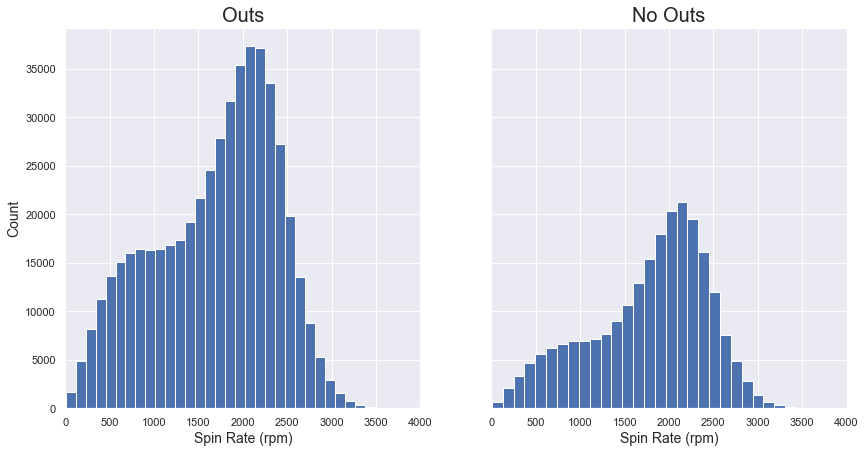

In [78]:
# plot the histograms

x_out = df_out['spin_rate']
x_no_out = df_no_out['spin_rate']

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(14,7))
ax[0].hist(x_out, bins=50)
ax[1].hist(x_no_out, bins=50)
ax[0].set_title('Outs', fontsize=20)
ax[1].set_title('No Outs', fontsize=20)
ax[0].set_ylabel('Count', fontsize=14)
ax[0].set_xlabel('Spin Rate (rpm)', fontsize=14)
ax[1].set_xlabel('Spin Rate (rpm)', fontsize=14)
ax[0].set_xlim(0, 4000)
ax[1].set_xlim(0, 4000);

Like the speed of the pitch, the spin rate on its own doesn't meaningfully help in predicitng an out.

For the top ten most frequent pitch types, how do they rank in terms of getting outs?  If out_made = 1  is an out and out_made = 0 is an event without an out, the higher the mean of those values, the more often the pitch leads to an out.

In [79]:
pitch_success = df.groupby("pitch_type")["out_made"].mean().sort_values(ascending = False)

In [80]:
pitch_success

pitch_type
Curveball             0.749964
Knuckle Curve         0.744539
Slider                0.742258
Splitter              0.738600
Changeup              0.715898
Knuckleball           0.696326
Cutter                0.694577
Four-seam Fastball    0.654082
Sinker                0.644836
Two-seam Fastball     0.639259
Name: out_made, dtype: float64

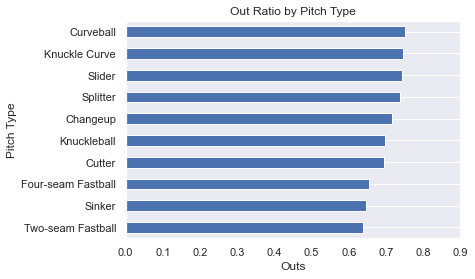

In [81]:
# plot the pitch types in order of their ratios of events with outs vs no outs

pitch_success.plot(kind = "barh")
plt.gca().invert_yaxis()
plt.xlabel("Outs")
plt.ylabel("Pitch Type")
plt.title("Out Ratio by Pitch Type")
plt.xticks(np.arange(0, 1, 0.1))
plt.grid(axis = 'x')
plt.show()

In [82]:
df.groupby('pitch_type').out_made.value_counts(normalize=True)

pitch_type          out_made
Changeup            1           0.715898
                    0           0.284102
Curveball           1           0.749964
                    0           0.250036
Cutter              1           0.694577
                    0           0.305423
Four-seam Fastball  1           0.654082
                    0           0.345918
Knuckle Curve       1           0.744539
                    0           0.255461
Knuckleball         1           0.696326
                    0           0.303674
Sinker              1           0.644836
                    0           0.355164
Slider              1           0.742258
                    0           0.257742
Splitter            1           0.738600
                    0           0.261400
Two-seam Fastball   1           0.639259
                    0           0.360741
Name: out_made, dtype: float64

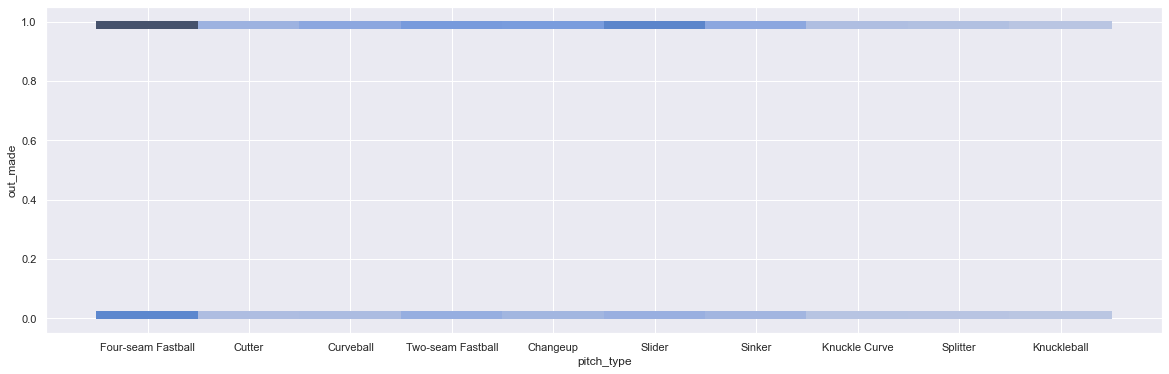

In [83]:
sns.set(rc={'figure.figsize':(20,6)})
sns.histplot(x=df['pitch_type'], y=df['out_made']);

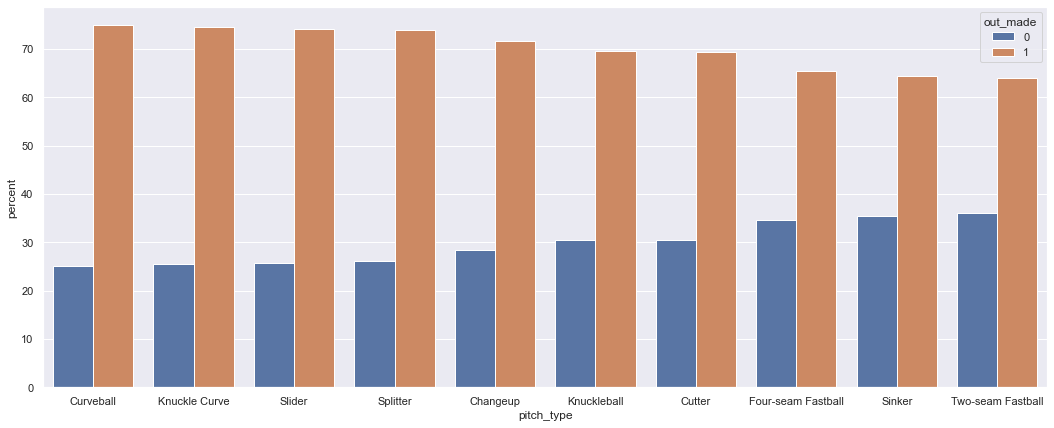

In [84]:
#sns.set(color_codes=True)
fig, ax = plt.subplots(figsize=(18, 7))

x = 'pitch_type'
y = 'out_made'

(df
.groupby(x)[y]
.value_counts(normalize=True).sort_values()
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.barplot,'data'), ax=ax,x=x,y='percent',hue=y));

From the 10 most frequently used pitches, I want to use the 5 of them with the highest ratio of getting outs for the model.

In [85]:
# keep the observations with the pitch types getting the highest percentage of outs

pitch_best_5 = ['Curveball', 'Knuckle Curve', 'Splitter', 'Slider', 'Changeup']

df = df[df['pitch_type'].isin(pitch_best_5)]
df = df.reset_index(drop=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283887 entries, 0 to 283886
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   inning        283887 non-null  int64  
 1   ab_id         283887 non-null  object 
 2   g_id          283887 non-null  int64  
 3   batter_id     283887 non-null  int64  
 4   pitcher_id    283887 non-null  int64  
 5   stand         283887 non-null  object 
 6   p_throws      283887 non-null  object 
 7   event         283887 non-null  object 
 8   horiz_loc     283887 non-null  float64
 9   vert_loc      283887 non-null  float64
 10  start_speed   283887 non-null  float64
 11  end_speed     283887 non-null  float64
 12  spin_rate     283887 non-null  float64
 13  spin_dir      283887 non-null  float64
 14  break_angle   283887 non-null  float64
 15  break_length  283887 non-null  float64
 16  break_y       283887 non-null  float64
 17  pitch_type    283887 non-null  object 
 18  b_co

In [86]:
# check new results of outs made or not with these 5 pitch types

df['out_made'].value_counts(normalize=True)

1    0.736268
0    0.263732
Name: out_made, dtype: float64

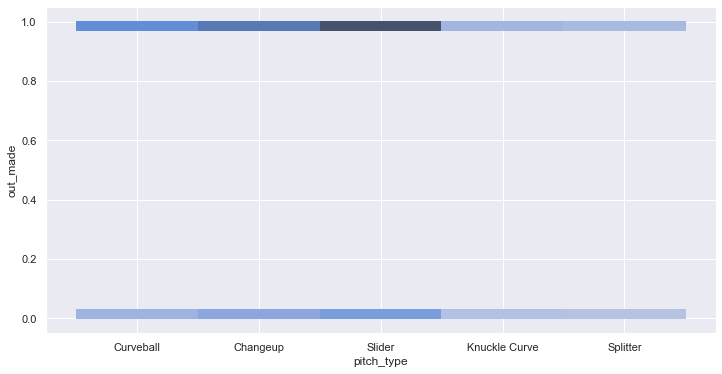

In [87]:
sns.set(rc={'figure.figsize':(12,6)})
sns.histplot(x=df['pitch_type'], y=df['out_made'])
sns.set(rc={'figure.figsize':(5,5)});

## Modeling

### Baseline Model

The baseline model is a dummy classifier using all other variables to predict out_made.

In [88]:
# define X and y and perform train test split with 20% in test set

X = df.drop(['out_made'], axis=1)
y = df['out_made']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [89]:
# instantiate and fit the model on train set

base_model = DummyClassifier(strategy='most_frequent')
base_model.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [90]:
# predict y and find accuracy on test data

y_pred = base_model.predict(X_test)

acc_base = accuracy_score(y_test, y_pred) * 100
print("Accuracy: {0}".format(acc_base))

Accuracy: 73.50029941174398


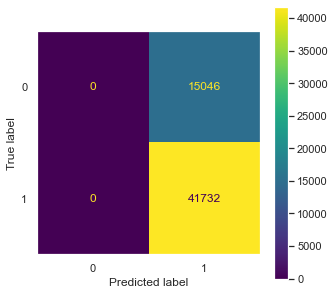

In [91]:
# plot confusion matrix

cm = confusion_matrix(y_test, y_pred, labels=base_model.classes_)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=base_model.classes_)
fig, ax = plt.subplots(figsize=(5, 5))
ax.grid(False)
cm_disp.plot(ax=ax);

In [92]:
# check ROC-AUC score

roc_auc = roc_auc_score(y_test, y_pred) * 100
print("Accuracy: {0}".format(roc_auc))

Accuracy: 50.0


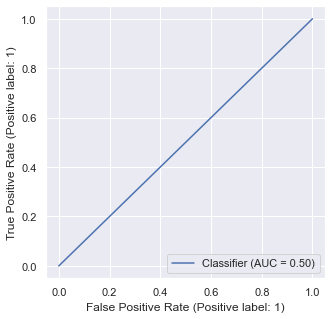

In [93]:
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()

### Decision Tree

The first model is a decision tree to try to see which independent variables are most important in predicting outs.  In addition to the pitch type, I want to consider the following variables: horiz_loc, vert_loc, start_speed, spin_rate, and spin_dir.

In [94]:
# create DataFrame of only the columns to use in model

df_model = df[['pitch_type', 'horiz_loc', 'vert_loc', 'start_speed', 'spin_rate', 'spin_dir', 'out_made']]

In [95]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283887 entries, 0 to 283886
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   pitch_type   283887 non-null  object 
 1   horiz_loc    283887 non-null  float64
 2   vert_loc     283887 non-null  float64
 3   start_speed  283887 non-null  float64
 4   spin_rate    283887 non-null  float64
 5   spin_dir     283887 non-null  float64
 6   out_made     283887 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 15.2+ MB


In [96]:
# one hot encoder for the pitch_type variable

#train_encoded = X_train_dt[['pitch_type']]
#test_encoded = X_test_dt[['pitch_type']]
ohe = OneHotEncoder(handle_unknown='ignore')
df_encoded = ohe.fit_transform(df_model[['pitch_type']])
#X_test_dt_encoded = ohe.transform(test_encoded)

df_encoded


<283887x5 sparse matrix of type '<class 'numpy.float64'>'
	with 283887 stored elements in Compressed Sparse Row format>

In [97]:
ohe_df = pd.DataFrame(df_encoded.todense(), columns=ohe.get_feature_names_out(), index=df_model.index)
#ohe_df

In [98]:
# replace the pitch type column with the encoded columns for pitch types

df_model_ohe = df_model.drop('pitch_type', axis=1)
df_model_ohe = pd.concat([df_model_ohe, ohe_df], axis=1)
#df_model_ohe

In [99]:
# define X and y and perform train test split with 20% in test set

X_dt = df_model_ohe.drop('out_made', axis=1)
y_dt = df_model_ohe['out_made']

X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(X_dt, y_dt, test_size=0.2, random_state=2)

In [100]:
# instantiate and fit model on the train set

dt = DecisionTreeClassifier(max_depth=2, random_state=2)
dt.fit(X_train_dt, y_train_dt)

DecisionTreeClassifier(max_depth=2, random_state=2)

In [101]:
# check accuracy on the training data

dt.score(X_train_dt, y_train_dt)

0.7439071106825357

In [102]:
# predict y and find accuracy on test data

y_pred_dt = dt.predict(X_test_dt)

acc_dt = accuracy_score(y_test_dt, y_pred_dt) * 100
print("Accuracy: {0}".format(acc_dt))

Accuracy: 74.06742047976329


The accuracy for the initial decision tree model didn't improve much over the dummy classifier.

In [103]:
# check ROC-AUC score

roc_auc = roc_auc_score(y_test_dt, y_pred_dt) * 100
print("ROC-AUC score: {0}".format(roc_auc))

ROC-AUC score: 51.94345237487005


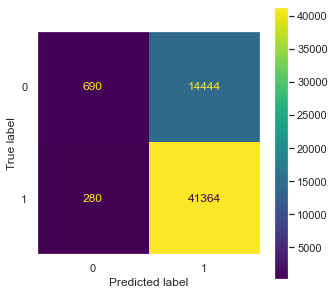

In [104]:
# plot confusion matrix

cm = confusion_matrix(y_test_dt, y_pred_dt, labels=dt.classes_)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt.classes_)
fig, ax = plt.subplots(figsize=(5, 5))
ax.grid(False)
cm_disp.plot(ax=ax);

Based on this matrix, the base decision tree model predicts almost all events to record an out, leading to a whole lot of false positives.

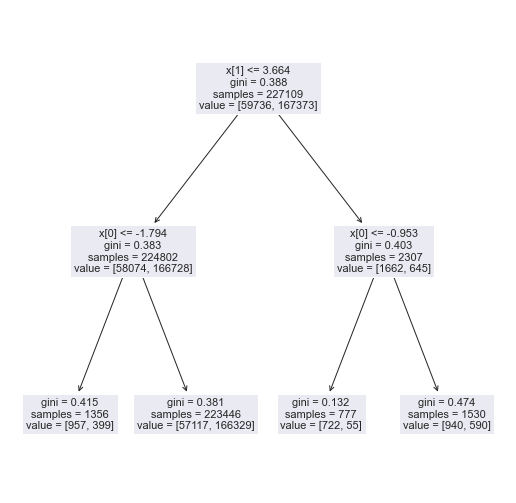

In [105]:
# look at decision tree

f, ax = plt.subplots(figsize=(9, 9))
plot_tree(dt, ax=ax);

I'll use GridSearch CV to adjust some hyperparameters to look for a better decision tree model.

In [106]:
# define X and y and perform train test split with 20% in test set

X_dt = df_model_ohe.drop('out_made', axis=1)
y_dt = df_model_ohe['out_made']

X_train_dt_grid, X_test_dt_grid, y_train_dt_grid, y_test_dt_grid = train_test_split(X_dt, y_dt, test_size=0.2, random_state=3)

In [107]:
# instantiate model

dt_grid = DecisionTreeClassifier(random_state=3)

In [108]:
# select parameters and instantiate GridSearchCV

params = {'max_depth': [2, 5, 7],
          'min_samples_split': [0.1, 0.3, 0.5],
          'criterion': ['entropy', 'log_loss']}

gs = GridSearchCV(estimator=dt_grid,
                  param_grid = params,
                  cv=5)

In [109]:
# fit grid search on the train set and call the best parameters

gs.fit(X_train_dt_grid, y_train_dt_grid)
gs.best_params_

{'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 0.1}

In [110]:
gs.cv_results_['mean_test_score'].max()

0.744188916911412

In [111]:
# check accuracy on the training data

gs.score(X_train_dt_grid, y_train_dt_grid)

0.7448934212206474

In [112]:
# predict y and find accuracy on test data

y_pred_dt_grid = gs.predict(X_test_dt_grid)

acc_dt_grid = accuracy_score(y_test_dt_grid, y_pred_dt_grid) * 100
print("Accuracy: {0}".format(acc_dt_grid))

Accuracy: 74.653915248864


Tuning the hyperparameters didn't increase the accuracy in a significant way.

In [113]:
# check ROC-AUC score

roc_auc = roc_auc_score(y_test_dt_grid, y_pred_dt_grid) * 100
print("ROC-AUC score: {0}".format(roc_auc))

ROC-AUC score: 52.48635601743341


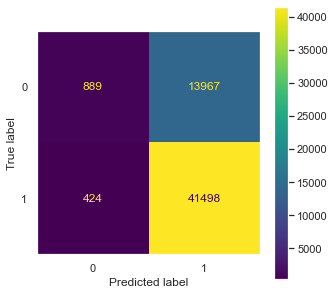

In [114]:
# plot confusion matrix

cm = confusion_matrix(y_test_dt_grid, y_pred_dt_grid, labels=gs.classes_)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gs.classes_)
fig, ax = plt.subplots(figsize=(5, 5))
ax.grid(False)
cm_disp.plot(ax=ax);

It appears that a single decision tree doesn't increase the accuracy much at all.  Tuning the model doesn't significantly change its propensity to select a positive outcome.

### LightGBM Model

In [115]:
# define X and y and perform train test split with 20% in test set

X_lgbm = df_model_ohe.drop('out_made', axis=1)
y_lgbm = df_model_ohe['out_made']

X_train_lgbm, X_test_lgbm, y_train_lgbm, y_test_lgbm = train_test_split(X_lgbm, y_lgbm, test_size=0.2, random_state=4)

In [116]:
# instantiate Light GBM model and set up GridSearchCV

lgbm = LGBMClassifier(verbosity= -1, objective='binary', random_state=4)

params_lgbm = [{'boosting': ['gbdt', 'goss'],
                'learning_rate': [0.1, 0.05, 0.01],
                'num_leaves': [31, 63, 127],
                'min_data_in_leaf': [100, 800, 1500]}]

gs = GridSearchCV(estimator=lgbm,
                  param_grid = params_lgbm,
                  cv=5)

In [117]:
# fit grid search on the train set and call the best parameters

gs.fit(X_train_lgbm, y_train_lgbm)
gs.best_params_

{'boosting': 'gbdt',
 'learning_rate': 0.05,
 'min_data_in_leaf': 100,
 'num_leaves': 63}

In [118]:
gs.cv_results_['mean_test_score'].max()

0.7503137238755409

In [119]:
# check accuracy on the training data

gs.score(X_train_lgbm, y_train_lgbm)

0.7519120774606026

In [120]:
# predict y and find accuracy on test data

y_pred_lgbm = gs.predict(X_test_lgbm)

acc_lgbm = accuracy_score(y_test_lgbm, y_pred_lgbm) * 100
print("Accuracy: {0}".format(acc_lgbm))

Accuracy: 74.68561766881538


In [121]:
# check ROC-AUC score

roc_auc = roc_auc_score(y_test_lgbm, y_pred_lgbm) * 100
print("ROC-AUC score: {0}".format(roc_auc))

ROC-AUC score: 53.27302696079831


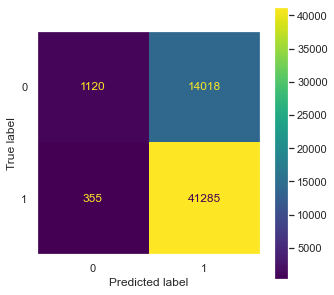

In [122]:
# plot confusion matrix

cm = confusion_matrix(y_test_lgbm, y_pred_lgbm, labels=gs.classes_)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gs.classes_)
fig, ax = plt.subplots(figsize=(5, 5))
ax.grid(False)
cm_disp.plot(ax=ax);

Using a tree based classification model isn't moving the accuracy of the predictions much at all.

### Logistic Regression

Next, I'll look at logistic regression to try to figure out which independent variables can best predict outs.

In [123]:
# define X and y and perform train test split with 20% in test set

X_log = df_model_ohe.drop('out_made', axis=1)
y_log = df_model_ohe['out_made']

X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_log, y_log, test_size=0.2, random_state=5)

In [124]:
# get numeric features for scaling

X_train_log_num = X_train_log[['horiz_loc', 'vert_loc', 'start_speed', 'spin_rate', 'spin_dir']].copy()
#X_train_log_num

In [125]:
# scale using MinMaxScaler with maximum value of 1 and minimum value of 0

scaler = MinMaxScaler()

scaler.fit(X_train_log_num)
X_train_log_scaled = pd.DataFrame(
    scaler.transform(X_train_log_num),
    index=X_train_log_num.index,
    columns=X_train_log_num.columns)

#X_train_log_scaled

In [126]:
# replace the pitch type column with the encoded columns for pitch types

X_train_log_final = X_train_log.drop(['horiz_loc', 'vert_loc', 'start_speed', 'spin_rate', 'spin_dir'], axis=1)
X_train_log_final = pd.concat([X_train_log_scaled, X_train_log_final], axis=1)
X_train_log_final

,horiz_loc,vert_loc,start_speed,spin_rate,spin_dir,pitch_type_Changeup,pitch_type_Curveball,pitch_type_Knuckle Curve,pitch_type_Slider,pitch_type_Splitter
38692,0.552324,0.582140,0.633010,0.303615,0.137603,0.0,1.0,0.0,0.0,0.0
268771,0.488698,0.540949,0.834951,0.259039,0.538768,0.0,0.0,0.0,1.0,0.0
116798,0.547374,0.602241,0.776699,0.394761,0.302111,1.0,0.0,0.0,0.0,0.0
18061,0.539175,0.664175,0.774757,0.200150,0.283363,0.0,1.0,0.0,0.0,0.0
62180,0.464839,0.605822,0.772816,0.361793,0.635471,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
136592,0.523163,0.568711,0.660194,0.245801,0.090909,0.0,0.0,1.0,0.0,0.0
232422,0.534257,0.523365,0.788350,0.245866,0.737369,1.0,0.0,0.0,0.0,0.0
124605,0.655203,0.447286,0.634951,0.115843,0.885498,0.0,1.0,0.0,0.0,0.0
20463,0.539175,0.573025,0.739806,0.141969,0.687563,1.0,0.0,0.0,0.0,0.0


In [127]:
# instantiate model

logreg = LogisticRegression(penalty='l2', random_state=5)

In [128]:
# select parameters and instantiate GridSearchCV

params = {'max_iter': [500, 1000],
          'C': [100, 1e5, 1e10],
          'solver': ['lbfgs', 'saga']}

gs = GridSearchCV(estimator=logreg,
                  param_grid = params,
                  cv=10)

In [129]:
# fit grid search on the train set and call the best parameters

#gs.fit(X_train_log_final, y_train_log)
#gs.best_params_

In [130]:
# intantiate best logistic regression model per the grid search

logreg_best = LogisticRegression(C=100, max_iter=500, solver='lbfgs', penalty='l2', random_state=5)

In [131]:
logreg_best.fit(X_train_log_final, y_train_log)

LogisticRegression(C=100, max_iter=500, random_state=5)

In [132]:
# cross validation

cv_results = cross_validate(
                    estimator=logreg_best,
                    X=X_train_log_final,
                    y=y_train_log,
                    cv=5,
                    return_train_score=True
)

In [133]:
cv_results['train_score']

array([0.73647537, 0.73649188, 0.73650289, 0.73650839, 0.73646581])

In [134]:
cv_results['test_score']

array([0.73642728, 0.73633922, 0.73647131, 0.73655938, 0.73659761])

Run preprocessing steps on the test data set

In [135]:
# get numeric features for scaling

X_test_log_num = X_test_log[['horiz_loc', 'vert_loc', 'start_speed', 'spin_rate', 'spin_dir']].copy()
#X_test_log_num

In [136]:
# scale using MinMaxScaler with maximum value of 1 and minimum value of 0

scaler = MinMaxScaler()

scaler.fit(X_test_log_num)
X_test_log_scaled = pd.DataFrame(
    scaler.transform(X_test_log_num),
    index=X_test_log_num.index,
    columns=X_test_log_num.columns)

#X_test_log_scaled

In [137]:
# replace the pitch type column with the encoded columns for pitch types

X_test_log_final = X_test_log.drop(['horiz_loc', 'vert_loc', 'start_speed', 'spin_rate', 'spin_dir'], axis=1)
X_test_log_final = pd.concat([X_test_log_scaled, X_test_log_final], axis=1)
X_test_log_final

,horiz_loc,vert_loc,start_speed,spin_rate,spin_dir,pitch_type_Changeup,pitch_type_Curveball,pitch_type_Knuckle Curve,pitch_type_Slider,pitch_type_Splitter
13130,0.479121,0.721168,0.476543,0.524695,0.089198,0.0,0.0,1.0,0.0,0.0
268664,0.511322,0.616891,0.641975,0.421533,0.072459,0.0,1.0,0.0,0.0,0.0
42274,0.484068,0.559439,0.518519,0.044886,0.336463,0.0,1.0,0.0,0.0,0.0
42305,0.510939,0.550415,0.725926,0.053842,0.666918,0.0,0.0,0.0,1.0,0.0
184127,0.776139,0.443270,0.723457,0.192127,0.534127,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
43267,0.568842,0.355794,0.629630,0.279931,0.150233,0.0,1.0,0.0,0.0,0.0
224949,0.636588,0.545540,0.725926,0.189834,0.227723,0.0,0.0,0.0,1.0,0.0
113853,0.628207,0.594350,0.725926,0.307665,0.186900,0.0,0.0,0.0,1.0,0.0
282697,0.601257,0.591825,0.753086,0.571980,0.663601,0.0,0.0,0.0,0.0,1.0


In [138]:
# predict y and find accuracy

y_pred_log = logreg_best.predict(X_test_log_final)

acc_log = accuracy_score(y_test_log, y_pred_log) * 100
print("Accuracy: {0}".format(acc_log))

Accuracy: 73.97935820212054


In [139]:
# check ROC-AUC score

roc_auc = roc_auc_score(y_test_log, y_pred_log) * 100
print("ROC-AUC score: {0}".format(roc_auc))

ROC-AUC score: 50.776252013971


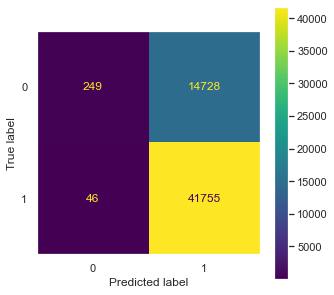

In [140]:
# plot confusion matrix

cm = confusion_matrix(y_test_log, y_pred_log, labels=logreg_best.classes_)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg_best.classes_)
fig, ax = plt.subplots(figsize=(5, 5))
ax.grid(False)
cm_disp.plot(ax=ax);

The logistic regression model doesn't improve the accuracy in making predictions either, so I'll try another type of model, k-Nearest Neighbors.

### k-Nearest Neighbors

In [141]:
# define X and y and perform train test split with 20% in test set

X_knn = df_model_ohe.drop('out_made', axis=1)
y_knn = df_model_ohe['out_made']

X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X_knn, y_knn, test_size=0.2, random_state=6)

In [142]:
# split training data into train and validation sets

X_t_knn, X_val_knn, y_t_knn, y_val_knn = train_test_split(X_train_knn, y_train_knn,
                                          random_state=6,
                                          test_size=0.2)

In [143]:
# instantiate the k-Nearest Neighbors model

knn = KNeighborsClassifier(n_neighbors=15)

In [144]:
# use standard scaler to scale X variables

ss = StandardScaler()
X_ind = X_t_knn.index
X_col = X_t_knn.columns

X_t_knn_s = pd.DataFrame(ss.fit_transform(X_t_knn))
X_t_knn_s.index = X_ind
X_t_knn_s.columns = X_col

X_val_ind = X_val_knn.index
X_val_knn_s = pd.DataFrame(ss.transform(X_val_knn))
X_val_knn_s.index = X_val_ind
X_val_knn_s.columns = X_col

knn.fit(X_t_knn_s, y_t_knn)
print(f"training accuracy: {knn.score(X_t_knn_s, y_t_knn)}")
print(f"Val accuracy: {knn.score(X_val_knn_s, y_val_knn)}")


training accuracy: 0.7544293207549246
Val accuracy: 0.737814275020915


In [145]:
# try different k values to see what happens to the accuracy scores

k_scores_train = {}
k_scores_val = {}

for k in range(1, 16):
    knn = KNeighborsClassifier(n_neighbors=k)
    accuracy_score_t = []
    accuracy_score_v = []
      
    knn.fit(X_t_knn_s, y_t_knn)
        
    y_pred_t_knn = knn.predict(X_t_knn_s)
    y_pred_val_knn = knn.predict(X_val_knn_s)
        
    accuracy_score_t.append(accuracy_score(y_t_knn, y_pred_t_knn))
    accuracy_score_v.append(accuracy_score(y_val_knn, y_pred_val_knn))
               
    k_scores_train[k] = np.mean(accuracy_score_t)
    k_scores_val[k] = np.mean(accuracy_score_v)

In [146]:
k_scores_train

{1: 1.0,
 2: 0.8201192160143543,
 3: 0.8186826795532977,
 4: 0.7846296102638053,
 5: 0.7850038802996362,
 6: 0.7719704766989383,
 7: 0.7699835431263656,
 8: 0.7640337503508782,
 9: 0.7634998651527076,
 10: 0.7605057048660608,
 11: 0.7588159857337069,
 12: 0.7580234138931239,
 13: 0.7564823019808792,
 14: 0.7554640673245747,
 15: 0.7544293207549246}

In [147]:
k_scores_val

{1: 0.6354629915019153,
 2: 0.5540486988683898,
 3: 0.6786579190700541,
 4: 0.6352868653956233,
 5: 0.7006516665932808,
 6: 0.6729338206155607,
 7: 0.7143454713574919,
 8: 0.6977676016027475,
 9: 0.7241424860199903,
 10: 0.7108229492316499,
 11: 0.7295143322618995,
 12: 0.7198053806525472,
 13: 0.733609264233191,
 14: 0.726233983532209,
 15: 0.737814275020915}

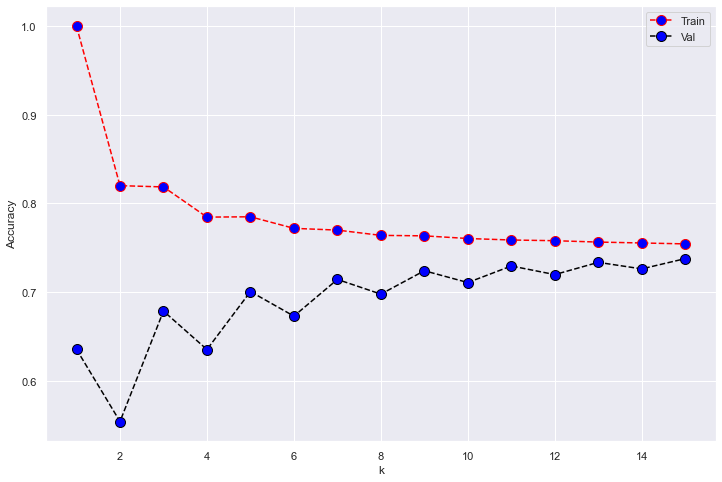

In [148]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(list(k_scores_train.keys()), list(k_scores_train.values()),
        color='red', linestyle='dashed', marker='o',  
         markerfacecolor='blue', markersize=10, label='Train')
ax.plot(list(k_scores_val.keys()), list(k_scores_val.values()),
        color='black', linestyle='dashed', marker='o',  
         markerfacecolor='blue', markersize=10, label='Val')
ax.set_xlabel('k')
ax.set_ylabel('Accuracy')
plt.legend();

In [149]:
# use standard scaler to scale X_test variables

X_ind = X_test_knn.index
X_col = X_test_knn.columns

X_test_knn_s = pd.DataFrame(ss.transform(X_test_knn))
X_test_knn_s.index = X_ind
X_test_knn_s.columns = X_col


In [150]:
# predict y and find accuracy

y_pred_knn = knn.predict(X_test_knn_s)

acc_knn = accuracy_score(y_test_knn, y_pred_knn) * 100
print("Accuracy: {0}".format(acc_knn))

Accuracy: 73.63591531931381


Comparing the accuracy provided from all of the models attempted, there is no model that signicantly affects the ability to predict outs.

In [151]:
print("Baseline Accuracy:                ", round((acc_base), ndigits=1), "%")
print("Initial Decision Tree Accuracy:   ", round((acc_dt), ndigits=1), "%")
print("DT Grid Search Accuracy:          ", round((acc_dt_grid), ndigits=1), "%")
print("Light GBM Accuracy:               ", round((acc_lgbm), ndigits=1), "%")
print("Logistic Regression Accuracy:     ", round((acc_log), ndigits=1), "%")
print("k-Nearest Neighbor Accuracy:      ", round((acc_knn), ndigits=1), "%")

Baseline Accuracy:                 73.5 %
Initial Decision Tree Accuracy:    74.1 %
DT Grid Search Accuracy:           74.7 %
Light GBM Accuracy:                74.7 %
Logistic Regression Accuracy:      74.0 %
k-Nearest Neighbor Accuracy:       73.6 %


### Balanced Number of Dependent Variable

Let's balance the data with the same number of plays where there are outs and no outs and see if that helps predictions.

In [152]:
# balance the data

out = df_model_ohe[df_model_ohe["out_made"]==1]
no_out = df_model_ohe[df_model_ohe["out_made"]==0]
out_reduced = out.sample(n=len(no_out), random_state=7)
df_balanced = pd.concat([no_out, out_reduced], axis=0)

In [153]:
df_balanced['out_made'].value_counts()

1    74870
0    74870
Name: out_made, dtype: int64

### Decision Tree

In [154]:
# define X and y and perform train test split with 20% in test set

X_dt = df_balanced.drop('out_made', axis=1)
y_dt = df_balanced['out_made']

X_train_dt_grid, X_test_dt_grid, y_train_dt_grid, y_test_dt_grid = train_test_split(X_dt, y_dt, test_size=0.2, random_state=8)

In [155]:
# instantiate model

dt_grid = DecisionTreeClassifier(random_state=8)

In [156]:
# select parameters and instantiate GridSearchCV

params = {'max_depth': [2, 5, 7],
          'min_samples_split': [0.1, 0.3, 0.5],
          'criterion': ['entropy', 'log_loss']}

gs = GridSearchCV(estimator=dt_grid,
                  param_grid = params,
                  cv=5)

In [157]:
# fit grid search on the train set and call the best parameters

gs.fit(X_train_dt_grid, y_train_dt_grid)
gs.best_params_

{'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 0.1}

In [158]:
gs.cv_results_['mean_test_score'].max()

0.5624749338304762

In [159]:
# check accuracy on the training data

gs.score(X_train_dt_grid, y_train_dt_grid)

0.5653883397889675

In [160]:
# predict y and find accuracy on test data

y_pred_dt_grid = gs.predict(X_test_dt_grid)

acc_dt_grid_bal = accuracy_score(y_test_dt_grid, y_pred_dt_grid) * 100
print("Accuracy: {0}".format(acc_dt_grid_bal))

Accuracy: 55.9803659676773


The improvement of the accuracy versus the 50% of the balanced data is greater than I was getting when modeling the unbalanced data. 

In [161]:
# check ROC-AUC score

roc_auc = roc_auc_score(y_test_dt_grid, y_pred_dt_grid) * 100
print("ROC-AUC score: {0}".format(roc_auc))

ROC-AUC score: 55.96865484221105


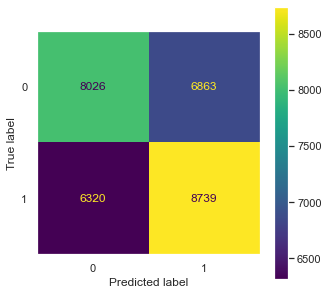

In [162]:
# plot confusion matrix

cm = confusion_matrix(y_test_dt_grid, y_pred_dt_grid, labels=gs.classes_)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gs.classes_)
fig, ax = plt.subplots(figsize=(5, 5))
ax.grid(False)
cm_disp.plot(ax=ax);

### LightGBM

In [163]:
# define X and y and perform train test split with 20% in test set

X_lgbm = df_balanced.drop('out_made', axis=1)
y_lgbm = df_balanced['out_made']

X_train_lgbm, X_test_lgbm, y_train_lgbm, y_test_lgbm = train_test_split(X_lgbm, y_lgbm, test_size=0.2, random_state=9)

In [164]:
# instantiate Light GBM model and set up GridSearchCV

lgbm = LGBMClassifier(verbosity= -1, objective='binary', random_state=9)

params_lgbm = [{'boosting': ['gbdt', 'goss'],
                'learning_rate': [0.1, 0.05, 0.01],
                'num_leaves': [31, 63, 127],
                'min_data_in_leaf': [100, 800, 1500]}]

gs = GridSearchCV(estimator=lgbm,
                  param_grid = params_lgbm,
                  cv=5)

In [165]:
# fit grid search on the train set and call the best parameters

gs.fit(X_train_lgbm, y_train_lgbm)
gs.best_params_

{'boosting': 'gbdt',
 'learning_rate': 0.1,
 'min_data_in_leaf': 100,
 'num_leaves': 31}

In [166]:
gs.cv_results_['mean_test_score'].max()

0.5801889191695607

In [167]:
# check accuracy on the training data

gs.score(X_train_lgbm, y_train_lgbm)

0.6037965807399492

In [168]:
# predict y and find accuracy on test data

y_pred_lgbm = gs.predict(X_test_lgbm)

acc_lgbm_bal = accuracy_score(y_test_lgbm, y_pred_lgbm) * 100
print("Accuracy: {0}".format(acc_lgbm_bal))

Accuracy: 58.24762922398825


In [169]:
# check ROC-AUC score

roc_auc = roc_auc_score(y_test_lgbm, y_pred_lgbm) * 100
print("ROC-AUC score: {0}".format(roc_auc))

ROC-AUC score: 58.24609089206718


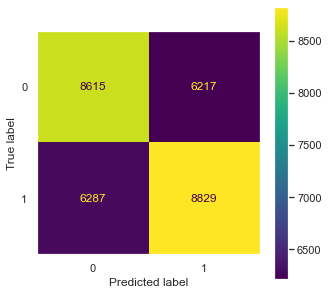

In [170]:
# plot confusion matrix

cm = confusion_matrix(y_test_lgbm, y_pred_lgbm, labels=gs.classes_)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gs.classes_)
fig, ax = plt.subplots(figsize=(5, 5))
ax.grid(False)
cm_disp.plot(ax=ax);

### Logistic Regression

Next, I'll look at logistic regression to try to figure out which independent variables can best predict outs.

In [171]:
# define X and y and perform train test split with 20% in test set

X_log = df_balanced.drop('out_made', axis=1)
y_log = df_balanced['out_made']

X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_log, y_log, test_size=0.2, random_state=10)

In [172]:
# get numeric features for scaling

X_train_log_num = X_train_log[['horiz_loc', 'vert_loc', 'start_speed', 'spin_rate', 'spin_dir']].copy()
#X_train_log_num

In [173]:
# scale using MinMaxScaler with maximum value of 1 and minimum value of 0

scaler = MinMaxScaler()

scaler.fit(X_train_log_num)
X_train_log_scaled = pd.DataFrame(
    scaler.transform(X_train_log_num),
    index=X_train_log_num.index,
    columns=X_train_log_num.columns)

#X_train_log_scaled

In [174]:
# replace the pitch type column with the encoded columns for pitch types

X_train_log_final = X_train_log.drop(['horiz_loc', 'vert_loc', 'start_speed', 'spin_rate', 'spin_dir'], axis=1)
X_train_log_final = pd.concat([X_train_log_scaled, X_train_log_final], axis=1)
X_train_log_final

,horiz_loc,vert_loc,start_speed,spin_rate,spin_dir,pitch_type_Changeup,pitch_type_Curveball,pitch_type_Knuckle Curve,pitch_type_Slider,pitch_type_Splitter
35895,0.606287,0.634795,0.737864,0.127424,0.184764,0.0,1.0,0.0,0.0,0.0
72586,0.707748,0.569281,0.735922,0.221911,0.324068,1.0,0.0,0.0,0.0,0.0
258289,0.675132,0.520741,0.910680,0.210829,0.455908,0.0,0.0,0.0,1.0,0.0
150773,0.739587,0.517878,0.656311,0.315573,0.621480,1.0,0.0,0.0,0.0,0.0
275070,0.686236,0.627393,0.796117,0.080039,0.617041,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
36246,0.596671,0.612496,0.844660,0.246642,0.494307,0.0,0.0,0.0,1.0,0.0
195059,0.562465,0.585888,0.640777,0.248585,0.058857,0.0,0.0,1.0,0.0,0.0
196655,0.578420,0.487611,0.712621,0.098421,0.083080,0.0,1.0,0.0,0.0,0.0
9646,0.584179,0.669871,0.739806,0.278282,0.305048,0.0,0.0,0.0,1.0,0.0


In [175]:
# instantiate model

logreg = LogisticRegression(penalty='l2', random_state=10)

In [176]:
# select parameters and instantiate GridSearchCV

params = {'max_iter': [500, 1000],
          'C': [100, 1e5, 1e10],
          'solver': ['lbfgs', 'saga']}

gs = GridSearchCV(estimator=logreg,
                  param_grid = params,
                  cv=10)

In [177]:
# fit grid search on the train set and call the best parameters

gs.fit(X_train_log_final, y_train_log)
gs.best_params_

{'C': 100000.0, 'max_iter': 500, 'solver': 'saga'}

In [178]:
# intantiate best logistic regression model per the grid search

logreg_best = LogisticRegression(C=1e10, max_iter=500, solver='saga', penalty='l2', random_state=5)

In [179]:
logreg_best.fit(X_train_log_final, y_train_log)

LogisticRegression(C=10000000000.0, max_iter=500, random_state=5, solver='saga')

In [180]:
# cross validation

cv_results = cross_validate(
                    estimator=logreg_best,
                    X=X_train_log_final,
                    y=y_train_log,
                    cv=5,
                    return_train_score=True
)

In [181]:
cv_results['train_score']

array([0.54357059, 0.54377928, 0.54229188, 0.54290753, 0.5444623 ])

In [182]:
cv_results['test_score']

array([0.542051  , 0.54221796, 0.54749979, 0.54161449, 0.53969447])

Run preprocessing steps on the test data set

In [183]:
# get numeric features for scaling

X_test_log_num = X_test_log[['horiz_loc', 'vert_loc', 'start_speed', 'spin_rate', 'spin_dir']].copy()
#X_test_log_num

In [184]:
# scale using MinMaxScaler with maximum value of 1 and minimum value of 0

scaler = MinMaxScaler()

scaler.fit(X_test_log_num)
X_test_log_scaled = pd.DataFrame(
    scaler.transform(X_test_log_num),
    index=X_test_log_num.index,
    columns=X_test_log_num.columns)

#X_test_log_scaled

In [185]:
# replace the pitch type column with the encoded columns for pitch types

X_test_log_final = X_test_log.drop(['horiz_loc', 'vert_loc', 'start_speed', 'spin_rate', 'spin_dir'], axis=1)
X_test_log_final = pd.concat([X_test_log_scaled, X_test_log_final], axis=1)
X_test_log_final

,horiz_loc,vert_loc,start_speed,spin_rate,spin_dir,pitch_type_Changeup,pitch_type_Curveball,pitch_type_Knuckle Curve,pitch_type_Slider,pitch_type_Splitter
94085,0.501231,0.483407,0.716381,0.454289,0.691305,0.0,0.0,0.0,0.0,1.0
112489,0.492298,0.458475,0.572127,0.273165,0.630859,0.0,0.0,0.0,0.0,1.0
142562,0.429186,0.459543,0.801956,0.211545,0.619201,1.0,0.0,0.0,0.0,0.0
72897,0.494035,0.619092,0.833741,0.440634,0.718407,1.0,0.0,0.0,0.0,0.0
112285,0.493290,0.497790,0.652812,0.496008,0.302980,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
48878,0.541304,0.579177,0.723716,0.231076,0.398863,0.0,0.0,0.0,1.0,0.0
221325,0.568778,0.463721,0.559902,0.427003,0.157756,0.0,1.0,0.0,0.0,0.0
64988,0.461157,0.454640,0.704156,0.349632,0.668651,1.0,0.0,0.0,0.0,0.0
241915,0.479800,0.553637,0.611247,0.480144,0.087923,0.0,0.0,1.0,0.0,0.0


In [186]:
# predict y and find accuracy

y_pred_log = logreg_best.predict(X_test_log_final)

acc_log_bal = accuracy_score(y_test_log, y_pred_log) * 100
print("Accuracy: {0}".format(acc_log_bal))

Accuracy: 54.67476960064111


In [187]:
# check ROC-AUC score

roc_auc = roc_auc_score(y_test_log, y_pred_log) * 100
print("ROC-AUC score: {0}".format(roc_auc))

ROC-AUC score: 54.69184333120416


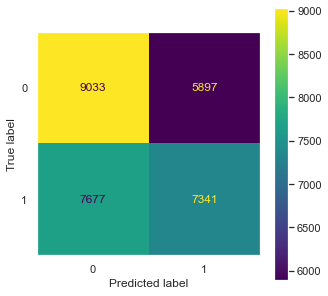

In [188]:
# plot confusion matrix

cm = confusion_matrix(y_test_log, y_pred_log, labels=logreg_best.classes_)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg_best.classes_)
fig, ax = plt.subplots(figsize=(5, 5))
ax.grid(False)
cm_disp.plot(ax=ax);

The logistic regression wasn't as accurate on the balanced data, specifically predicting more events without an out, including more false negatives.

### k-Nearest Neighbors

In [189]:
# define X and y and perform train test split with 20% in test set

X_knn = df_balanced.drop('out_made', axis=1)
y_knn = df_balanced['out_made']

X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X_knn, y_knn, test_size=0.2, random_state=11)

In [190]:
# split training data into train and validation sets

X_t_knn, X_val_knn, y_t_knn, y_val_knn = train_test_split(X_train_knn, y_train_knn,
                                          random_state=11,
                                          test_size=0.2)

In [191]:
# instantiate the k-Nearest Neighbors model

knn = KNeighborsClassifier(n_neighbors=15)

In [192]:
# use standard scaler to scale X variables

ss = StandardScaler()
X_ind = X_t_knn.index
X_col = X_t_knn.columns

X_t_knn_s = pd.DataFrame(ss.fit_transform(X_t_knn))
X_t_knn_s.index = X_ind
X_t_knn_s.columns = X_col

X_val_ind = X_val_knn.index
X_val_knn_s = pd.DataFrame(ss.transform(X_val_knn))
X_val_knn_s.index = X_val_ind
X_val_knn_s.columns = X_col

knn.fit(X_t_knn_s, y_t_knn)
print(f"training accuracy: {knn.score(X_t_knn_s, y_t_knn)}")
print(f"Val accuracy: {knn.score(X_val_knn_s, y_val_knn)}")


training accuracy: 0.6422631035238383
Val accuracy: 0.5527776618389749


In [193]:
# try different k values to see what happens to the accuracy scores

k_scores_train = {}
k_scores_val = {}

for k in range(1, 16):
    knn = KNeighborsClassifier(n_neighbors=k)
    accuracy_score_t = []
    accuracy_score_v = []
      
    knn.fit(X_t_knn_s, y_t_knn)
        
    y_pred_t_knn = knn.predict(X_t_knn_s)
    y_pred_val_knn = knn.predict(X_val_knn_s)
        
    accuracy_score_t.append(accuracy_score(y_t_knn, y_pred_t_knn))
    accuracy_score_v.append(accuracy_score(y_val_knn, y_pred_val_knn))
               
    k_scores_train[k] = np.mean(accuracy_score_t)
    k_scores_val[k] = np.mean(accuracy_score_v)

In [194]:
k_scores_train

{1: 1.0,
 2: 0.7671157117068234,
 3: 0.7681800632350025,
 4: 0.7123224776434005,
 5: 0.7130111756910459,
 6: 0.6859536902737053,
 7: 0.6861415170139722,
 8: 0.6698527647052686,
 9: 0.6690805881063934,
 10: 0.6564544572328948,
 11: 0.6571327204616364,
 12: 0.6481796458422464,
 13: 0.6478457316373274,
 14: 0.6417309277597487,
 15: 0.6422631035238383}

In [195]:
k_scores_val

{1: 0.5271505488542928,
 2: 0.5274427146375057,
 3: 0.5385032764305688,
 4: 0.5348720731249217,
 5: 0.5412162444175467,
 6: 0.5406736508201511,
 7: 0.5477691055553237,
 8: 0.5459743728870153,
 9: 0.548186485245628,
 10: 0.5463917525773195,
 11: 0.5491047205642974,
 12: 0.5519846404273968,
 13: 0.552694185900914,
 14: 0.5518594265203055,
 15: 0.5527776618389749}

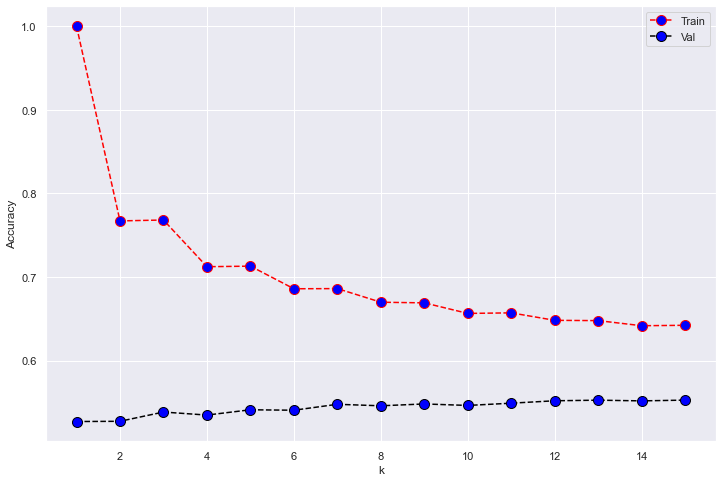

In [196]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(list(k_scores_train.keys()), list(k_scores_train.values()),
        color='red', linestyle='dashed', marker='o',  
         markerfacecolor='blue', markersize=10, label='Train')
ax.plot(list(k_scores_val.keys()), list(k_scores_val.values()),
        color='black', linestyle='dashed', marker='o',  
         markerfacecolor='blue', markersize=10, label='Val')
ax.set_xlabel('k')
ax.set_ylabel('Accuracy')
plt.legend();

In [197]:
# use standard scaler to scale X_test variables

X_ind = X_test_knn.index
X_col = X_test_knn.columns

X_test_knn_s = pd.DataFrame(ss.transform(X_test_knn))
X_test_knn_s.index = X_ind
X_test_knn_s.columns = X_col


In [198]:
# predict y and find accuracy

y_pred_knn = knn.predict(X_test_knn_s)

acc_knn_bal = accuracy_score(y_test_knn, y_pred_knn) * 100
print("Accuracy: {0}".format(acc_knn_bal))

Accuracy: 55.80005342593829


Comparison of accuracy scores from the models using the balanced data:

In [199]:
print("Decision Tree Accuracy:           ", round((acc_dt_grid_bal), ndigits=1), "%")
print("Light GBM Accuracy:               ", round((acc_lgbm_bal), ndigits=1), "%")
print("Logistic Regression Accuracy:     ", round((acc_log_bal), ndigits=1), "%")
print("k-Nearest Neighbor Accuracy:      ", round((acc_knn_bal), ndigits=1), "%")

Decision Tree Accuracy:            56.0 %
Light GBM Accuracy:                58.2 %
Logistic Regression Accuracy:      54.7 %
k-Nearest Neighbor Accuracy:       55.8 %


### Assessment

Balancing the data allows all of the models to perform better in predicting the outcome of an at bat compared to the 50% chance of being correct.  The Decision Tree model has a bit higher accuracy than the Light GBM, but both of those perform the best.